# Mini-Project for Fundamentals of Machine Learning Course
In this study, facial expression recognition was performed on the face images from the Facial Expression Recognition Challenge (FER2013) dataset.

One motivation for representation learning is that learning algorithms can design features more effectively and efficiently than humans can. However, this challenge does not explicitly require entries to use representation learning. The dataset, assembled from the internet, is designed for facial expression classification.

The data consists of grayscale images of faces, each measuring 48x48 pixels. The faces have been automatically aligned to be roughly centered and occupy a similar area within each image. The task is to categorize each face based on the emotion expressed, assigning it to one of seven categories (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral). The dataset contains a total of 35,887 examples.

## 1. Prerequisite
This section provides some basic steps for accessing and visualizing the dataset.

In [1]:
import os
import random
import sys

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch import nn
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, log_loss, make_scorer, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.pipeline import Pipeline

import xgboost as xgb
from catboost import CatBoostClassifier, Pool
from lightgbm import LGBMClassifier

import cv2
from cv2 import imread, imwrite
from tqdm import tqdm

from joblib import dump
import joblib

import warnings
warnings.filterwarnings('ignore')

### Accessing data

In [2]:
def parse_data(data: pd.DataFrame):
    """
    Reads input dataframe then return arrays of images and labels
    """
    image_array = np.zeros(shape=(len(data), 48, 48))
    image_label = np.array(list(map(int, data['emotion'])))
    
    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, 'pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48))
        image_array[i] = image
        
    return image_array, image_label

In [3]:
def show_img(images: np.ndarray, labels: np.ndarray):
    """
    Visualize images and labels respectively
    """
    _, axarr=plt.subplots(nrows=2, ncols=5, figsize=(18, 9))
    axarr=axarr.flatten()
    for idx, label in enumerate(labels[:10]):
        axarr[idx].imshow(images[idx], cmap='gray')
        axarr[idx].set_xticks([])
        axarr[idx].set_yticks([])
        axarr[idx].set_title("Label:{}".format(label))

In [4]:
## load dataset here
df = pd.read_csv("../data/icml_face_data.csv")
# df.head()

The ```emotion``` column contains a numeric code ranging from 0 to 6, inclusive, for the emotion expressed by the image. The "pixels" column contains a string surrounded in quotes for each image.

In [5]:
## parsing data here
images, labels = parse_data(df)

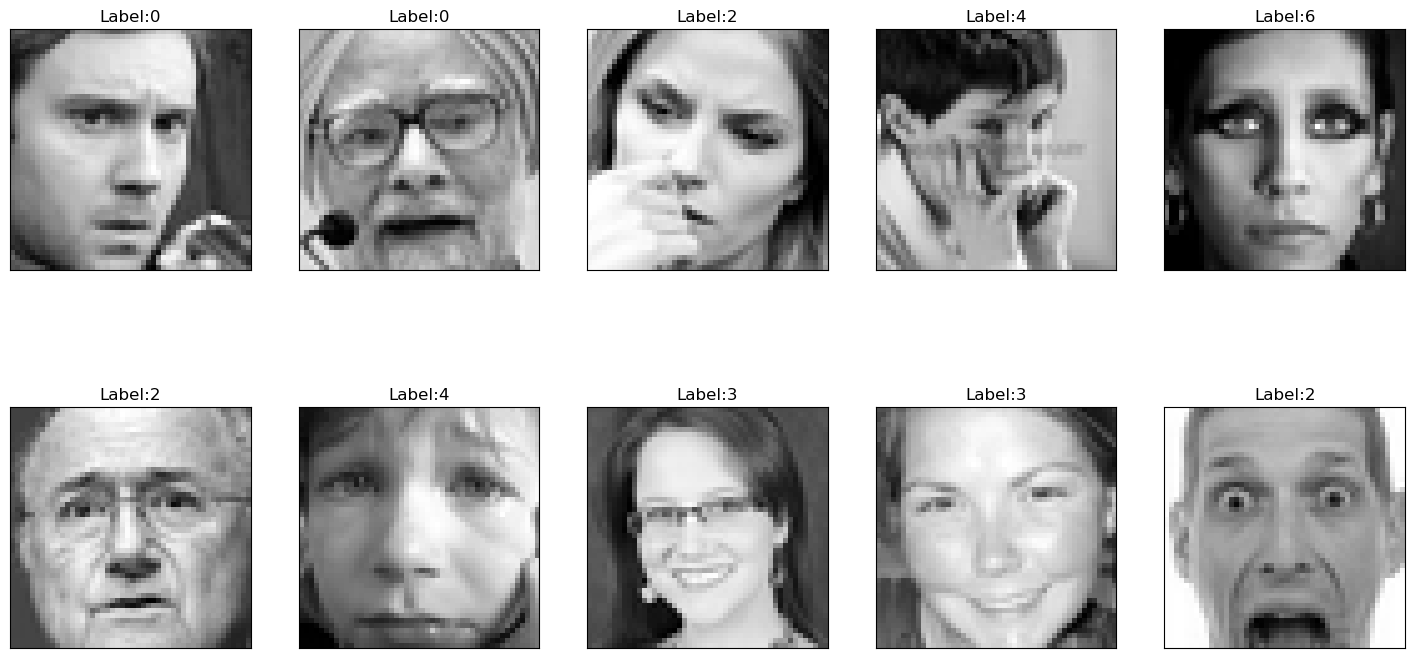

In [6]:
## showing images here
show_img(images, labels)

### EDA

In [7]:
print(df.isnull().sum())

emotion    0
pixels     0
dtype: int64


In [8]:
def check_pixels(pixels):  # check whether a string of pixels represents a 48x48 image or not.
    image = np.fromstring(pixels, dtype=int, sep=' ')
    return len(image) == 48 * 48

invalid_pixels = df[~df['pixels'].apply(check_pixels)]
print(f'Number of invalid pixel entries: {len(invalid_pixels)}')

Number of invalid pixel entries: 0


In [9]:
# drop duplicate
df = df.drop_duplicates(subset=['pixels'])
df = df.reset_index(drop=True)
df.shape

(34034, 2)

We'll assess image quality by checking for meaningful content. If an image only contains one unique pixel, then we can infer that the image is a solid color and will not have any useful information for classifying emotions.

In [10]:
def has_one_unique_value(pixels):
    # Convert the pixel string to a numpy array
    pixel_array = np.fromstring(pixels, dtype=int, sep=' ')
    # Check if the array contains only one unique value
    return len(np.unique(pixel_array)) == 1

rows_with_one_unique_value = df['pixels'].apply(has_one_unique_value)
num_rows_with_one_unique_value = rows_with_one_unique_value.sum()

print(f'Number of rows with exactly one unique value in "pixels": {num_rows_with_one_unique_value}')

Number of rows with exactly one unique value in "pixels": 1


In [11]:
df = df[~rows_with_one_unique_value]
df = df.reset_index(drop=True)
df.shape

(34033, 2)

Let's check the labels' distribution

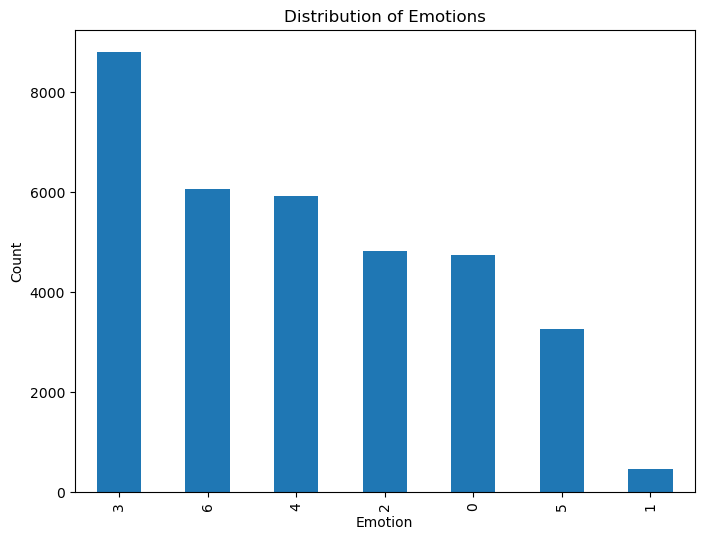

In [12]:
emotion_counts = df['emotion'].value_counts()

plt.figure(figsize=(8, 6))
emotion_counts.plot(kind='bar')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.title('Distribution of Emotions')
plt.show()

## 2. Principle Component Analysis

Unsupervised learning can be further categorized into two main tasks: data transformation and clustering. In this study, we will focus on data transformation using unsupervised learning techniques. These techniques aim to modify the data to make it easier for computers and humans to analyze and understand.

One of the most common applications of unsupervised data transformation is dimensionality reduction. This process reduces the number of features (dimensions) in the data. When the data has a high number of features, it can be computationally expensive and difficult to analyze. Dimensionality reduction techniques help to overcome these challenges.

Principal Component Analysis (PCA) is a popular technique for dimensionality reduction. It transforms the data into a new set of features called principal components (PCs). These PCs are ordered by their importance, capturing the most significant variations in the data. By selecting a subset of the most informative PCs, we can achieve a significant reduction in data size while preserving the essential information for analysis.

Question 1: Can you visualize the data projected onto two principal components? (2 points)

> The original shape of the images is `(35887, 48, 48)` that means each image can be thought of as a point in a `48 x 48 = 2,304` dimensional space. Visualizing data in such a high-dimensional space is not possible directly. We need to reduce the dimensionality of the data to two dimensions by PCA.

> Here are the steps to visualize the data projected onto two dimensions aka principal components:
> 1. Flatten the Images: Convert each 48x48 image into a 1-dimensional array of length 2304.
> 2. Apply PCA: Use PCA to reduce the dimensionality from 2304 to 2.
> 3. Plot the Data: Visualize the 2-dimensional data using a scatter plot.

In [6]:
from sklearn.decomposition import PCA
pca=PCA(n_components=2)
num_samples, height, width = images.shape
images_flat = images.reshape(num_samples, height * width)
pca.fit(images_flat) ## modify images' array to the appropriate shape

PCA(n_components=2)

In [7]:
# Transform the data
images_pca = pca.transform(images_flat)
print("Original shape:", images.shape)
print("Flattened shape:", images_flat.shape)
print("PCA shape:", images_pca.shape)

Original shape: (35887, 48, 48)
Flattened shape: (35887, 2304)
PCA shape: (35887, 2)


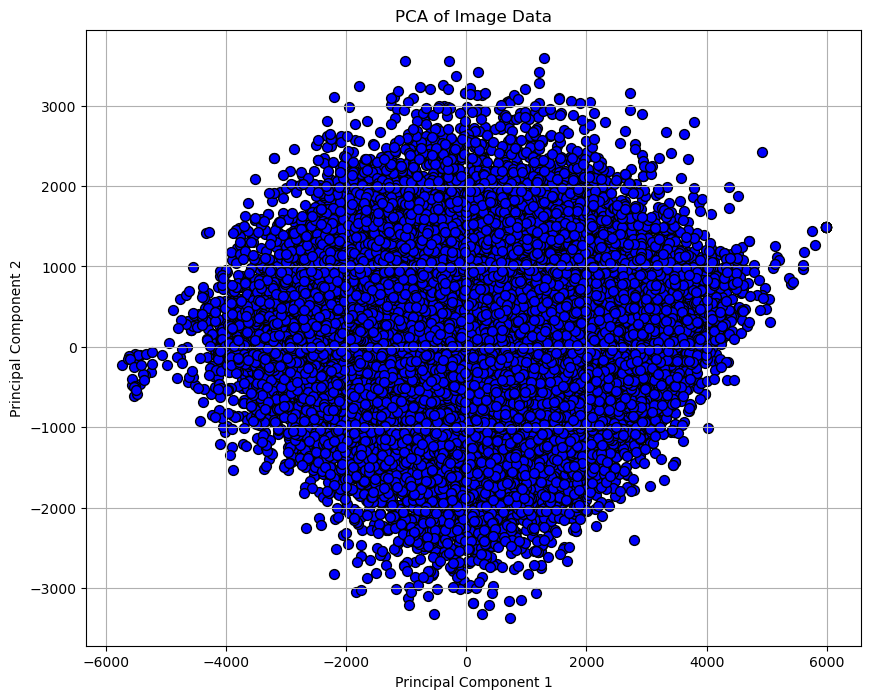

In [15]:
# Visualize the data projected onto the two principal components
plt.figure(figsize=(10, 8))
plt.scatter(images_pca[:, 0], images_pca[:, 1], c='blue', edgecolor='k', s=50)
plt.title('PCA of Image Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()

> The plot above is the result of PCA and also answers  **question 1**

Question 2: How to determine the optimal number of principal components using ```pca.explained_variance_```? Explain your selection process. (2 points)

**ANSWER:**

The explained variance helps you understand how much information (or variance) is retained when you reduce the dimensionality of your data by selecting a subset of principal components. 

In order to determine the `optimal number of principal components` using pca.explained_variance_, we begin by fitting PCA without specifying the number of components, considering all available components. 

Next, we calculate the ratio of explained variance for each component and sum them up cumulatively. 

By finding the point where the cumulative explained variance reaches or surpasses 95%, we can identify the number of components that explain most of the variance. 

Number of components explaining 95.0% variance: 255


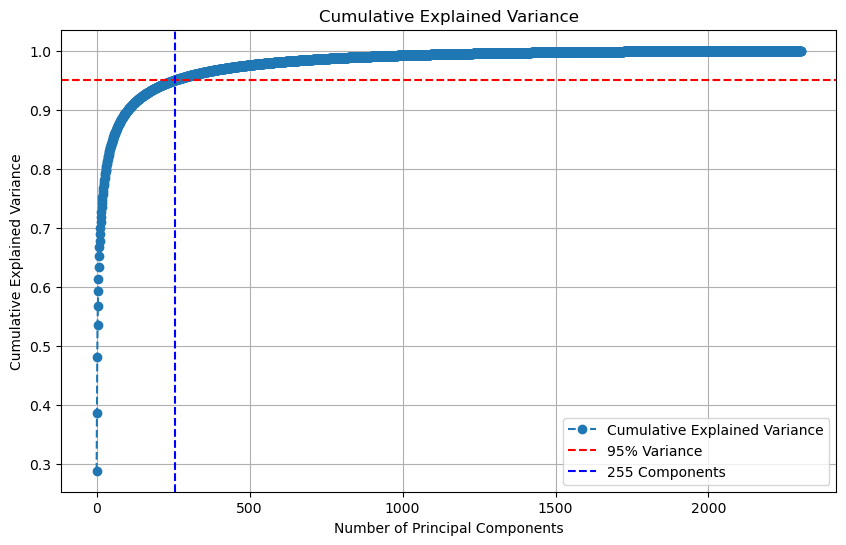

In [9]:
# Initialize PCA without specifying the number of components to consider all components
pca = PCA()
pca.fit(images_flat)

# Calculate the explained variance ratio and its cumulative sum
explained_variance_ratios = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratios)

# Determine the number of components that explain 95% of the variance
target_variance = 0.95
num_components = np.searchsorted(cumulative_explained_variance, target_variance) + 1
print(f"Number of components explaining {target_variance * 100}% variance: {num_components}")

# Plot the cumulative explained variance
plt.figure(figsize=(10, 6))
plt.plot(cumulative_explained_variance, marker='o', linestyle='--', label='Cumulative Explained Variance')
plt.axhline(y=target_variance, color='r', linestyle='--', label=f'{int(target_variance * 100)}% Variance')
plt.axvline(x=num_components, color='b', linestyle='--', label=f'{num_components} Components')
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.legend(loc='best')
plt.grid(True)
plt.show()

> To confirm our findings, we visualize the cumulative explained variance graphically.

> The intersection of the red and blue lines defines the principal components needed to explain 95% of the data.


Reconstructed Images after PCA:


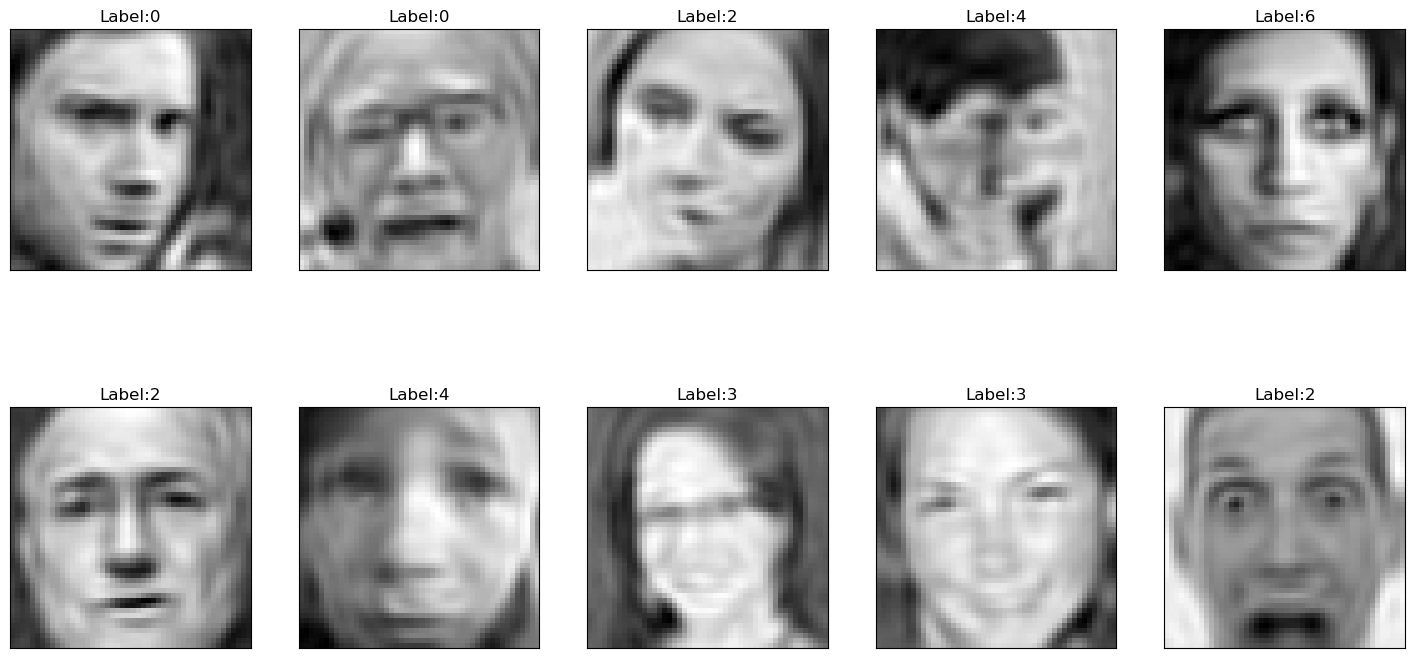

In [17]:
# Apply PCA after determined number of components
pca = PCA(n_components=num_components)
images_pca = pca.fit_transform(images_flat)

# Inverse transform to reconstruct the images
images_reconstructed = pca.inverse_transform(images_pca)
images_reconstructed = images_reconstructed.reshape(num_samples, height, width)

# Show the images after PCA 
print("Reconstructed Images after PCA:")
show_img(images_reconstructed, labels)

## 3. Image Classification

The classification task will compare the performance using both:

- Original data: The data before applying PCA.
- Transformed data: The data projected onto the optimal number of principal components identified earlier. Utilize the **optimal number of principal components** identified in the previous question.

Compare the performance of **4** different classification algorithms (3 machine learning and 1 MLP models) in both formats above. (4 points)

Perform hyperparameter tuning using ```GridSearchCV``` for each classification method. (1 point)

Inspiration: Draw inspiration from the example provided in the scikit-learn documentation: https://scikit-learn.org/dev/auto_examples/datasets/plot_iris_dataset.html

### Working with original data

While some of the images have a close view of the face, some may not. We will use Haar Cascade to detect faces and crop out the surrounding environment. Afterwards, we will resize the images.

In [18]:
face_cascade = cv2.CascadeClassifier('/content/drive/MyDrive/LABS/haarcascade_frontalface_default.xml')

# Convert string of pixels to numpy array and crop the image
def img_crop(df):
    # Function to process each image
    def process_image(pixels):
        try:
            #convert to numpy array
            img = np.fromstring(pixels, dtype=int, sep=' ').reshape(48, 48).astype('uint8')

            # Face detection
            face_detected = face_cascade.detectMultiScale(img)

            # Check if exactly one face is detected
            if len(face_detected) == 1:
                (x, y, w, h) = face_detected[0]
                # Crop the image
                img_cropped = img[y + 1: y + h, x + 1 : x + w]
                # Adjust the cropped image size to 48x48 pixels
                img_reshaped = cv2.resize(img_cropped, (48, 48))
                return ' '.join(map(str, img_reshaped.flatten()))
            else:
                # If there is no or more than one face, return the original image
                return pixels
        except Exception as e:
            # If there is an error, return the original image
            return pixels

    df['pixels'] = df['pixels'].apply(process_image)

    return df

data = img_crop(df.copy())

In [65]:
# Convert to numpy
def array_conversions(df):
    img_arrays = df['pixels'].apply(lambda x: np.fromstring(x, dtype=int, sep=' ').reshape(48, 48))
    img_arrays = np.stack(img_arrays)
    return img_arrays

images = array_conversions(data)
labels = data['emotion'].values

In [66]:
## splitting data into train/val/test subsets here
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [67]:
# Flatten from 2D to 1D
X_train = X_train.reshape(X_train.shape[0], -1)
X_valid = X_valid.reshape(X_valid.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

#### XGBoost

In [22]:
X_train.shape

(21780, 2304)

In [24]:
unique_classes = np.unique(y_train)
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)
# Tính toán scale_pos_weight cho mỗi lớp
scale_pos_weight = [class_weights[i] / min(class_weights) for i in range(len(class_weights))]

def weight_loss(y_true, y_pred_proba):
    loss = log_loss(y_true, y_pred_proba, labels=np.unique(y_true))
    return loss

scorer = make_scorer(weight_loss, greater_is_better=False, needs_proba=True)

xgb_model = xgb.XGBClassifier(objective='multi:softmax',
                              num_class=7,
                              max_depth=8,
                              tree_method="gpu_hist",
                              device="cuda",
                              scale_pos_weight=scale_pos_weight,
                              use_label_encoder=False)

xg_param_grid = {
    'n_estimators': [100, 200],
    'gamma': [0.1, 0.2],
    'reg_alpha': [0.1, 0.5],
    'learning_rate': [0.01, 0.1],
}

xg_grid_search = GridSearchCV(estimator=xgb_model, param_grid=xg_param_grid, scoring=scorer, cv=3, verbose=0)

xg_grid_search.fit(X_train[:1500], y_train[:1500])

zg_best_params = xg_grid_search.best_params_

xg_best_model = xg_grid_search.best_estimator_
xg_y_pred_proba = xg_best_model.predict_proba(X_test)
xg_y_pred = np.argmax(xg_y_pred_proba, axis=1)

print(classification_report(y_test, xg_y_pred))

xg_accuracy = accuracy_score(y_test, xg_y_pred)
xg_test_loss = weight_loss(y_test, xg_y_pred_proba)
print(f'XGBOOST Accuracy: {xg_accuracy:.4f}, Test Loss: {xg_test_loss:.4f}')

              precision    recall  f1-score   support

           0       0.41      0.23      0.30      1008
           1       0.67      0.02      0.05        82
           2       0.35      0.21      0.26       935
           3       0.52      0.72      0.61      1773
           4       0.34      0.37      0.36      1168
           5       0.62      0.46      0.53       625
           6       0.39      0.47      0.43      1216

    accuracy                           0.44      6807
   macro avg       0.47      0.36      0.36      6807
weighted avg       0.44      0.44      0.42      6807

XGBOOST Accuracy: 0.4419, Test Loss: 1.5481


In [25]:
xg_best_model.save_model('../models/saved_models/original_xgboost.json')

#### Catboost

In [29]:
def weight_loss(y_true, y_pred_proba):
    loss = log_loss(y_true, y_pred_proba, labels=np.unique(y_true))
    return loss

scorer = make_scorer(weight_loss, greater_is_better=False, needs_proba=True)

catboost_model = CatBoostClassifier(loss_function='MultiClass',
                                    depth=10,
                                    task_type='GPU',
                                    class_weights=class_weights.tolist(),
                                    verbose=0)

cat_param_grid = {
    'learning_rate': [0.01, 0.1],
    'iterations': [100, 200],
    'l2_leaf_reg': [1, 3]
}

cat_grid_search = GridSearchCV(estimator=catboost_model, param_grid=cat_param_grid, scoring=scorer, cv=3, verbose=0)

cat_grid_search.fit(X_train[:1500], y_train[:1500])

cat_best_params = cat_grid_search.best_params_

cat_best_model = cat_grid_search.best_estimator_
cat_y_pred_proba = cat_best_model.predict_proba(X_test)
cat_y_pred = np.argmax(cat_y_pred_proba, axis=1)

print(classification_report(y_test, cat_y_pred))

cat_accuracy = accuracy_score(y_test, cat_y_pred)
cat_test_loss = weight_loss(y_test, cat_y_pred_proba)
print(f'CatBoost Accuracy: {cat_accuracy:.4f}, Test Loss: {cat_test_loss:.4f}')

              precision    recall  f1-score   support

           0       0.25      0.12      0.16      1008
           1       0.06      0.29      0.10        82
           2       0.25      0.07      0.11       935
           3       0.47      0.50      0.48      1773
           4       0.29      0.28      0.29      1168
           5       0.29      0.59      0.39       625
           6       0.31      0.36      0.33      1216

    accuracy                           0.33      6807
   macro avg       0.27      0.31      0.26      6807
weighted avg       0.33      0.33      0.31      6807

CatBoost Accuracy: 0.3254, Test Loss: 1.8461


In [32]:
cat_best_model.save_model('../models/saved_models/original_catboost.cbm')

#### LightGBM

In [35]:
unique_classes = np.unique(y_train)
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))

def weight_loss(y_true, y_pred_proba):
    loss = log_loss(y_true, y_pred_proba, labels=np.unique(y_true))
    return loss

scorer = make_scorer(weight_loss, greater_is_better=False, needs_proba=True)

lgbm_model = LGBMClassifier(objective='multiclass',
                            num_class=len(np.unique(labels)),
                            device='gpu',
                            class_weight=class_weight_dict)

lgbm_param_grid = {
    'num_leaves': [31, 50, 70],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 15, 20],
    'min_child_samples': [10, 20, 30],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [0, 0.1, 0.5]
}

lgbm_grid_search = GridSearchCV(estimator=lgbm_model, param_grid=lgbm_param_grid,
                           scoring='accuracy', cv=3, verbose=0, n_jobs=-1)

lgbm_grid_search.fit(X_train, y_train)

lgbm_best_params = lgbm_grid_search.best_params_

lgbm_best_model = lgbm_grid_search.best_estimator_
lgbm_y_pred_proba = lgbm_best_model.predict_proba(X_test)
lgbm_y_pred = np.argmax(lgbm_y_pred_proba, axis=1)

print(classification_report(y_test, lgbm_y_pred))

lgbm_accuracy = accuracy_score(y_test, lgbm_y_pred)
lgbm_test_loss = weight_loss(y_test, lgbm_y_pred_proba)
print(f'CatBoost Accuracy: {lgbm_accuracy:.4f}, Test Loss: {lgbm_test_loss:.4f}')

              precision    recall  f1-score   support

           0       0.35      0.28      0.31      1008
           1       0.77      0.12      0.21        82
           2       0.30      0.25      0.27       935
           3       0.59      0.62      0.60      1773
           4       0.33      0.36      0.34      1168
           5       0.47      0.53      0.50       625
           6       0.39      0.45      0.42      1216

    accuracy                           0.43      6807
   macro avg       0.46      0.37      0.38      6807
weighted avg       0.43      0.43      0.42      6807

CatBoost Accuracy: 0.4282, Test Loss: 1.4853


In [37]:
lgbm_best_model.booster_.save_model('../models/saved_models/original_lightbgm.pkl')

#### MLP

In [105]:
class OriginalDataset(Dataset):
    def __init__(self, images, labels):
        super().__init__()
        self.images = images
        self.labels = labels
        self.transform = ToTensor()

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.transform(self.images[idx].reshape(-1, self.images[idx].shape[0])).float(), self.labels[idx]

train_dataset = OriginalDataset(X_train, y_train)
valid_dataset = OriginalDataset(X_valid, y_valid)
test_dataset = OriginalDataset(X_test, y_test)
training_dataloader = DataLoader(train_dataset, batch_size=2048, shuffle=False)
validation_dataloader = DataLoader(valid_dataset, batch_size=2048, shuffle=False)
testing_dataloader = DataLoader(test_dataset, batch_size=2048, shuffle=False)

In [106]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.LazyLinear(128), nn.ELU(), nn.BatchNorm1d(128),
            nn.Linear(128, 32), nn.ELU(), nn.BatchNorm1d(32),
            nn.Linear(32, 7)
        )
        self.softmax = nn.Softmax()
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.flatten(x)
        x = self.net(x)
        return self.softmax(x)

In [107]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MLP().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()
n_epochs = 20
for epoch in range(n_epochs):
    model.train()
    training_loss = 0
    validation_loss = 0
    for inputs, labels in training_dataloader:
        inputs = inputs.to(device)
        # print(labels.shape)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        training_loss += loss.item()
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        for inputs, labels in validation_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            validation_loss += loss.item()
    print(f"Epoch {epoch+1:>2d}/{n_epochs}, Training Loss: {training_loss/len(training_dataloader):>5.6f}, Validation Loss: {validation_loss/len(validation_dataloader):5.6f}")

Epoch  1/20, Training Loss: 1.895699, Validation Loss: 1.887796
Epoch  2/20, Training Loss: 1.843814, Validation Loss: 1.848794
Epoch  3/20, Training Loss: 1.820129, Validation Loss: 1.826833
Epoch  4/20, Training Loss: 1.803039, Validation Loss: 1.813117
Epoch  5/20, Training Loss: 1.792140, Validation Loss: 1.851129
Epoch  6/20, Training Loss: 1.783499, Validation Loss: 1.836380
Epoch  7/20, Training Loss: 1.772940, Validation Loss: 1.812759
Epoch  8/20, Training Loss: 1.765990, Validation Loss: 1.819143
Epoch  9/20, Training Loss: 1.758116, Validation Loss: 1.805813
Epoch 10/20, Training Loss: 1.749154, Validation Loss: 1.790764
Epoch 11/20, Training Loss: 1.742009, Validation Loss: 1.800996
Epoch 12/20, Training Loss: 1.737707, Validation Loss: 1.793572
Epoch 13/20, Training Loss: 1.732252, Validation Loss: 1.799994
Epoch 14/20, Training Loss: 1.728080, Validation Loss: 1.828510
Epoch 15/20, Training Loss: 1.721624, Validation Loss: 1.818639
Epoch 16/20, Training Loss: 1.718056, Va

In [108]:
model.eval()
predictions = []
actual_labels = []
for images, labels in testing_dataloader:
    input_ids = images.to(device)
    # attention_mask = batch['attention_mask'].to(device)
    labels = labels.to(device)  # Get actual labels

    with torch.no_grad():
        outputs = model(input_ids)
        # logits = outputs.logits
        # probabilities = logits
        predicted_labels = torch.argmax(outputs, dim=-1)
        predictions.extend(predicted_labels.cpu().numpy())
        actual_labels.extend(labels.cpu().numpy())

print("Accuracy:",accuracy_score(actual_labels, np.round(predictions)))
print(classification_report(actual_labels, np.round(predictions)))

Accuracy: 0.3628617599529896
              precision    recall  f1-score   support

           0       0.26      0.19      0.22      1008
           1       0.00      0.00      0.00        82
           2       0.06      0.00      0.00       935
           3       0.47      0.62      0.54      1773
           4       0.28      0.36      0.32      1168
           5       0.40      0.41      0.40       625
           6       0.31      0.41      0.35      1216

    accuracy                           0.36      6807
   macro avg       0.26      0.28      0.26      6807
weighted avg       0.31      0.36      0.33      6807



#### Summarise

|   | Model | Accuracy |
|:-:|:-:|:-|
| **0** | **XGBoost** | **0.4419** |
| 1 | CatBoost | 0.3254 |
| 2 | LightGBM | 0.4282 |
| 3 | MLP | 0.3628 |

### Working with PCA

#### XGBoost

In [10]:
# Apply PCA after determined number of components
pca = PCA(n_components=num_components)
images_pca = pca.fit_transform(images_flat)

# Inverse transform to reconstruct the images
images_reconstructed = pca.inverse_transform(images_pca)
images_reconstructed = images_reconstructed.reshape(num_samples, height, width)

X_train, X_test, y_train, y_test = train_test_split(images_pca, labels, test_size=0.2, random_state=42) 
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [11]:
X_train_small = X_train[:1500]  # Take the first 1500 data points
y_train_small = y_train[:1500]  # Corresponding labels

In [ ]:
unique_classes = np.unique(y_train)
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)
scale_pos_weight = [class_weights[i] / min(class_weights) for i in range(len(class_weights))]

def weight_loss(y_true, y_pred_proba):
    loss = log_loss(y_true, y_pred_proba, labels=np.unique(y_true))
    return loss

scorer = make_scorer(weight_loss, greater_is_better=False, needs_proba=True)

xgb_model = xgb.XGBClassifier(objective='multi:softmax',
                              max_depth=8,
                              tree_method="gpu_hist",
                              device="gpu",
                              scale_pos_weight=scale_pos_weight,
                              use_label_encoder=False)

xg_param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__gamma': [0.1, 0.2],
    'classifier__reg_alpha': [0.1, 0.5],
    'classifier__learning_rate': [0.01, 0.1],
}

xgb_pipeline = Pipeline([('scaler', StandardScaler()), ('classifier', xgb_model)])
xg_grid_search = GridSearchCV(estimator=xgb_pipeline, param_grid=xg_param_grid, scoring=scorer, cv=3, verbose=1)

xg_grid_search.fit(X_train_small, y_train_small)
xg_best_params = xg_grid_search.best_params_

xg_best_model = xg_grid_search.best_estimator_
xg_y_pred_proba = xg_best_model.predict_proba(X_test)
xg_y_pred = np.argmax(xg_y_pred_proba, axis=1)

print(classification_report(y_test, xg_y_pred))

xg_accuracy = accuracy_score(y_test, xg_y_pred)
xg_test_loss = weight_loss(y_test, xg_y_pred_proba)
print(f'XGBOOST Accuracy: {xg_accuracy:.4f}, Test Loss: {xg_test_loss:.4f}')

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV] END classifier__gamma=0.1, classifier__learning_rate=0.01, classifier__n_estimators=100, classifier__reg_alpha=0.1; total time=  56.7s
[CV] END classifier__gamma=0.1, classifier__learning_rate=0.01, classifier__n_estimators=100, classifier__reg_alpha=0.1; total time= 1.1min
[CV] END classifier__gamma=0.1, classifier__learning_rate=0.01, classifier__n_estimators=100, classifier__reg_alpha=0.1; total time=  54.5s
[CV] END classifier__gamma=0.1, classifier__learning_rate=0.01, classifier__n_estimators=100, classifier__reg_alpha=0.5; total time= 1.0min
[CV] END classifier__gamma=0.1, classifier__learning_rate=0.01, classifier__n_estimators=100, classifier__reg_alpha=0.5; total time=  56.4s
[CV] END classifier__gamma=0.1, classifier__learning_rate=0.01, classifier__n_estimators=100, classifier__reg_alpha=0.5; total time=  56.6s
[CV] END classifier__gamma=0.1, classifier__learning_rate=0.01, classifier__n_estimators=200, class

In [ ]:
dump(xg_best_model, '../models/saved_models/pca_xgboost.joblib')
print("Saved the best XGBoost model to xgb_best_model.joblib")

#### Catboost

In [ ]:
# Define a minimal parameter grid for the CatBoost model
catboost_param_grid = {
    'classifier__iterations': [100, 300],
    'classifier__learning_rate': [0.01, 0.1],
    'classifier__depth': [3, 5],
    'classifier__l2_leaf_reg': [1, 3],
}

# Create the CatBoost model
catboost_model = CatBoostClassifier()

# Create a pipeline with StandardScaler and CatBoost classifier
catboost_pipeline = Pipeline([('scaler', StandardScaler()), ('classifier', catboost_model)])

# Perform grid search with cross-validation
catboost_search = GridSearchCV(estimator=catboost_pipeline, param_grid=catboost_param_grid, cv=3, n_jobs=-1, verbose=2)
catboost_search.fit(X_train_small, y_train_small)

# Get the best model and parameters
catboost_best_model = catboost_search.best_estimator_
print(f"CatBoost best params: {catboost_search.best_params_}")
print(f"CatBoost best score: {catboost_search.best_score_}")

# Evaluate the best model on the test set
catboost_pred = catboost_best_model.predict(X_test)
accuracy = accuracy_score(y_test, catboost_pred)
print(f"CatBoost accuracy: {accuracy}")

# Save the best model to a file
dump(catboost_best_model, '../models/saved_models/pca_catboost.joblib')
print("Saved the best CatBoost model to catboost_best_model.joblib")

In [56]:
catboost_best_model = joblib.load('../models/saved_models/pca_catboost.joblib')

In [57]:
scaler = StandardScaler()
scaler.fit(X_train)
transformed_X_test = scaler.transform(X_test)
# Evaluate the best model on the test set
catboost_pred = catboost_best_model.predict(transformed_X_test)
accuracy = accuracy_score(y_test, catboost_pred)
print(f"CatBoost accuracy: {accuracy}")
print(classification_report(y_test, catboost_pred))

CatBoost accuracy: 0.17804402340484815
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       985
           1       0.00      0.00      0.00       102
           2       0.00      0.00      0.00      1043
           3       0.00      0.00      0.00      1765
           4       0.00      0.00      0.00      1210
           5       0.00      0.00      0.00       795
           6       0.18      1.00      0.30      1278

    accuracy                           0.18      7178
   macro avg       0.03      0.14      0.04      7178
weighted avg       0.03      0.18      0.05      7178



#### LightGBM

In [ ]:
# Define a minimal parameter grid for the LightGBM model
lgbm_param_grid = {
    'classifier__num_leaves': [20, 30],
    'classifier__learning_rate': [0.01, 0.1],
    'classifier__max_depth': [3, 5],
    'classifier__n_estimators': [100, 300],
}

# Create the LightGBM model
lgbm_model = LGBMClassifier()

# Create a pipeline with StandardScaler and LightGBM classifier
lgbm_pipeline = Pipeline([('scaler', StandardScaler()), ('classifier', lgbm_model)])

# Perform grid search with cross-validation
lgbm_search = GridSearchCV(estimator=lgbm_pipeline, param_grid=lgbm_param_grid, cv=3, n_jobs=-1, verbose=2)
lgbm_search.fit(X_train_small, y_train_small)

# Get the best model and parameters
lgbm_best_model = lgbm_search.best_estimator_
print(f"LightGBM best params: {lgbm_search.best_params_}")
print(f"LightGBM best score: {lgbm_search.best_score_}")

# Evaluate the best model on the test set
lgbm_pred = lgbm_best_model.predict(X_test)
lgbm_accuracy = accuracy_score(y_test, lgbm_pred)
print(f"LightGBM accuracy: {lgbm_accuracy}")


Fitting 3 folds for each of 16 candidates, totalling 48 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025318 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 65025
[LightGBM] [Info] Number of data points in the train set: 22967, number of used features: 255
[LightGBM] [Info] Start training from score -1.981905
[LightGBM] [Info] Start training from score -4.147411
[LightGBM] [Info] Start training from score -1.948046
[LightGBM] [Info] Start training from score -1.391664
[LightGBM] [Info] Start training from score -1.765673
[LightGBM] [Info] Start training from score -2.201107
[LightGBM] [Info] Start training from score -1.752023
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

In [ ]:
lgbm_best_model = joblib.load('../models/saved_models/pca_lgbm.joblib')

#### MLP

In [118]:
X_train.shape

(22967, 255)

In [11]:
class PCADataset(Dataset):
    def __init__(self, images, labels):
        super().__init__()
        self.images = images
        self.labels = labels
        self.transform = ToTensor()

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.transform(self.images[idx].reshape(-1, self.images[idx].shape[0])).float(), self.labels[idx]

train_dataset = PCADataset(X_train, y_train)
valid_dataset = PCADataset(X_valid, y_valid)
test_dataset = PCADataset(X_test, y_test)
training_dataloader = DataLoader(train_dataset, batch_size=2048, shuffle=False)
validation_dataloader = DataLoader(valid_dataset, batch_size=2048, shuffle=False)
testing_dataloader = DataLoader(test_dataset, batch_size=2048, shuffle=False)

In [12]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.LazyLinear(128), nn.ELU(), nn.BatchNorm1d(128),
            nn.Linear(128, 32), nn.ELU(), nn.BatchNorm1d(32),
            nn.Linear(32, 7)
        )
        self.softmax = nn.Softmax()
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.flatten(x)
        x = self.net(x)
        return self.softmax(x)

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MLP().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()
n_epochs = 20
for epoch in range(n_epochs):
    model.train()
    training_loss = 0
    validation_loss = 0
    for inputs, labels in training_dataloader:
        inputs = inputs.to(device)
        # print(labels.shape)
        labels = labels.type(torch.LongTensor)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        training_loss += loss.item()
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        for inputs, labels in validation_dataloader:
            inputs = inputs.to(device)
            labels = labels.type(torch.LongTensor)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            validation_loss += loss.item()
    print(f"Epoch {epoch+1:>2d}/{n_epochs}, Training Loss: {training_loss/len(training_dataloader):>5.6f}, Validation Loss: {validation_loss/len(validation_dataloader):5.6f}")

Epoch  1/20, Training Loss: 1.926131, Validation Loss: 1.909704
Epoch  2/20, Training Loss: 1.878025, Validation Loss: 1.867500
Epoch  3/20, Training Loss: 1.832978, Validation Loss: 1.826418
Epoch  4/20, Training Loss: 1.795039, Validation Loss: 1.797340
Epoch  5/20, Training Loss: 1.766507, Validation Loss: 1.783068
Epoch  6/20, Training Loss: 1.742861, Validation Loss: 1.774668
Epoch  7/20, Training Loss: 1.721363, Validation Loss: 1.768384
Epoch  8/20, Training Loss: 1.700505, Validation Loss: 1.763287
Epoch  9/20, Training Loss: 1.679899, Validation Loss: 1.759489
Epoch 10/20, Training Loss: 1.658989, Validation Loss: 1.756905
Epoch 11/20, Training Loss: 1.637979, Validation Loss: 1.755993
Epoch 12/20, Training Loss: 1.616836, Validation Loss: 1.755373
Epoch 13/20, Training Loss: 1.596022, Validation Loss: 1.754491
Epoch 14/20, Training Loss: 1.575873, Validation Loss: 1.753941
Epoch 15/20, Training Loss: 1.557045, Validation Loss: 1.753635
Epoch 16/20, Training Loss: 1.539484, Va

In [16]:
model.eval()
predictions = []
actual_labels = []
for images, labels in testing_dataloader:
    input_ids = images.to(device)
    # attention_mask = batch['attention_mask'].to(device)
    labels = labels.to(device)  # Get actual labels

    with torch.no_grad():
        outputs = model(input_ids)
        # logits = outputs.logits
        # probabilities = logits
        predicted_labels = torch.argmax(outputs, dim=-1)
        predictions.extend(predicted_labels.cpu().numpy())
        actual_labels.extend(labels.cpu().numpy())

print("Accuracy:",accuracy_score(actual_labels, np.round(predictions)))
print(classification_report(actual_labels, np.round(predictions)))

Accuracy: 0.4016439119531903
              precision    recall  f1-score   support

           0       0.31      0.26      0.29       985
           1       1.00      0.04      0.08       102
           2       0.34      0.27      0.30      1043
           3       0.49      0.61      0.54      1765
           4       0.30      0.31      0.31      1210
           5       0.52      0.51      0.51       795
           6       0.37      0.38      0.38      1278

    accuracy                           0.40      7178
   macro avg       0.48      0.34      0.34      7178
weighted avg       0.40      0.40      0.39      7178



#### Summarise

|   | Model | Accuracy |
|:-:|:-:|:-|
| 0 | XGBoost | 0.3266 |
| 1 | CatBoost | 0.3254 |
| **2** | **LightGBM** | **0.4272** |
| 3 | MLP | 0.4016 |

### Working with auto encoder

In [26]:
N_MAX = 4000

class AugmentedEmotionDataset(Dataset):
    def __init__(self, path_to_data, training=None):
        super().__init__()
        self.path = path_to_data
        self.data = []
        for label in range(7):
            label_path = f"{self.path}/{label}"
            if (training == 'train'):
                for item in os.listdir(label_path)[:N_MAX]:
                    self.data.append((f'{label_path}/{item}', label))
            else:
                for item in os.listdir(label_path):
                    self.data.append((f'{label_path}/{item}', label))

        random.Random(42).shuffle(self.data)
        self.transform = ToTensor()

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = imread(self.data[idx][0])
        label = self.data[idx][1]
        return self.transform(image[:, :, 1]).float(), label
    
train_dataset = AugmentedEmotionDataset('../data/images/train', training='train')
valid_dataset = AugmentedEmotionDataset('../data/images/valid')
test_dataset = AugmentedEmotionDataset('../data/images/test')

class AutoEncoder(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, 1), nn.ELU(), nn.BatchNorm2d(64), #64x48x48
            nn.Conv2d(64, 64, 3), nn.ELU(), nn.BatchNorm2d(64),#64x46x46
            nn.Conv2d(64, 4, 3), nn.ELU(), nn.BatchNorm2d(4),  #4x44x44
            nn.Conv2d(4, 4, 3), nn.ELU(), nn.BatchNorm2d(4),  #4x42x42
        )
        self.flattern = nn.Flatten()
        self.linear1 = nn.Linear(4*42*42, 256)
        self.linear2 = nn.Linear(256, 4*42*42)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(4, 4, 3), nn.ELU(), nn.BatchNorm2d(4),
            nn.ConvTranspose2d(4, 64, 3), nn.ELU(), nn.BatchNorm2d(64),
            nn.ConvTranspose2d(64, 64, 3), nn.ELU(), nn.BatchNorm2d(64),
            nn.ConvTranspose2d(64, 1, 1), nn.ELU(),
        )

    def encode(self, x):
        x = self.encoder(x)
        x = self.flattern(x)
        x = self.linear1(x)
        return x

    def decode(self, x):
        x = self.linear2(x)
        x = x.reshape(-1, 4, 42, 42)
        x = self.decoder(x)
        return x

    def forward(self, x):
        x = self.encode(x)
        x = self.decode(x)
        return x
    
features_extraction_model = AutoEncoder()#.to(device)
features_extraction_model.load_state_dict(torch.load("../models/saved_models/autoencoder_model_256.pth", map_location=torch.device('cpu')))
features_extraction_model.eval()

AutoEncoder(
  (encoder): Sequential(
    (0): Conv2d(1, 64, kernel_size=(1, 1), stride=(1, 1))
    (1): ELU(alpha=1.0)
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (4): ELU(alpha=1.0)
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(64, 4, kernel_size=(3, 3), stride=(1, 1))
    (7): ELU(alpha=1.0)
    (8): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1))
    (10): ELU(alpha=1.0)
    (11): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (flattern): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=7056, out_features=256, bias=True)
  (linear2): Linear(in_features=256, out_features=7056, bias=True)
  (decoder): Sequential(
    (0): ConvTranspose2d(4, 4, kernel_size=(3, 3), stride=(1, 1))
  

In [25]:
encoded_training_data = []
encoded_validation_data = []
encoded_testing_data = []

for i in tqdm(range(len(train_dataset)), ascii=True, ncols=100,   desc="training_data  "):
    with torch.no_grad():
        encoded_training_data.append(features_extraction_model.encode(train_dataset[i][0].unsqueeze(0)*255))
encoded_training_data = torch.cat(encoded_training_data, dim=0)

for i in tqdm(range(len(valid_dataset)), ascii=True, ncols=100, desc="validation_data"):
    with torch.no_grad():
        encoded_validation_data.append(features_extraction_model.encode(valid_dataset[i][0].unsqueeze(0)*255))
encoded_validation_data = torch.cat(encoded_validation_data, dim=0)

for i in tqdm(range(len(test_dataset)), ascii=True, ncols=100,       desc="testing_data   "):
    with torch.no_grad():
        encoded_testing_data.append(features_extraction_model.encode(test_dataset[i][0].unsqueeze(0)*255))
encoded_testing_data = torch.cat(encoded_testing_data, dim=0)

testing_data   : 100%|#########################################| 7178/7178 [00:15<00:00, 455.74it/s]


In [ ]:
torch.save(encoded_training_data, "../data/augmented_encoded_training_data.pt")
torch.save(encoded_validation_data, "../data/augmented_encoded_validation_data.pt")
torch.save(encoded_testing_data, "../data/augmented_encoded_testing_data.pt")

In [27]:
train_labels = []
valid_labels = []
test_labels = []
for i in tqdm(range(len(train_dataset)), ascii=True, ncols=100,  desc="training_data    "):
    train_labels.append(train_dataset[i][1])
for i in tqdm(range(len(valid_dataset)), ascii=True, ncols=100,  desc="validation_data  "):
    valid_labels.append(valid_dataset[i][1])
for i in tqdm(range(len(test_dataset)), ascii=True, ncols=100,   desc="test_data        "):
    test_labels.append(test_dataset[i][1])

test_data        : 100%|######################################| 7178/7178 [00:00<00:00, 9007.40it/s]


In [28]:
augmented_training_data = np.array(encoded_training_data)
augmented_validation_data = np.array(encoded_validation_data)
augmented_testing_data = np.array(encoded_testing_data)

In [29]:
classes = np.unique(train_labels)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=train_labels)
class_weights = dict(zip(classes, weights))

In [13]:
classification_model = CatBoostClassifier(
    iterations=5000,
    learning_rate=0.02,
    l2_leaf_reg=10,
    random_seed=42,
    depth=8,
    # loss_function=MultiClassObjective(),
    task_type="GPU",
    loss_function='MultiClassOneVsAll',
    class_weights=class_weights,
    # eval_metric='Logloss',
    classes_count=7,
    verbose=100)

classification_XGBoost_model = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=7,
    max_depth=8,
    tree_method="gpu_hist",
    device="cuda",
    scale_pos_weight=scale_pos_weight,
    use_label_encoder=False,
    n_estimators = 300,
    learning_rate = 0.02,
    verbosity = 2)

classification_lightGBM_model = LGBMClassifier(
    classifier__learning_rate = 0.1,
    classifier__max_depth = 5,
    classifier__n_estimators = 5000,
    classifier__num_leaves = 20,
    device="gpu"
)

In [30]:
classification_model.fit(augmented_training_data, train_labels, eval_set=(augmented_validation_data, valid_labels))

0:	learn: 0.6810451	test: 0.6844491	best: 0.6844491 (0)	total: 99.3ms	remaining: 8m 16s
100:	learn: 0.2829022	test: 0.4409592	best: 0.4409592 (100)	total: 5.48s	remaining: 4m 25s
200:	learn: 0.2365308	test: 0.4348151	best: 0.4348151 (200)	total: 10.9s	remaining: 4m 21s
300:	learn: 0.2188422	test: 0.4267048	best: 0.4267048 (300)	total: 16s	remaining: 4m 10s
400:	learn: 0.2062518	test: 0.4163150	best: 0.4163150 (400)	total: 21s	remaining: 4m 1s
500:	learn: 0.1958682	test: 0.4072771	best: 0.4072771 (500)	total: 25.4s	remaining: 3m 48s
600:	learn: 0.1871189	test: 0.3998935	best: 0.3998935 (600)	total: 29.9s	remaining: 3m 38s
700:	learn: 0.1793377	test: 0.3935722	best: 0.3935722 (700)	total: 34.4s	remaining: 3m 30s
800:	learn: 0.1725548	test: 0.3881627	best: 0.3881627 (800)	total: 39.4s	remaining: 3m 26s
900:	learn: 0.1664532	test: 0.3835386	best: 0.3835386 (900)	total: 43.8s	remaining: 3m 19s
1000:	learn: 0.1612268	test: 0.3797149	best: 0.3797149 (1000)	total: 48.2s	remaining: 3m 12s
1100:

In [31]:
y_pred = classification_model.predict(augmented_testing_data)
print(classification_report(test_labels, y_pred))

              precision    recall  f1-score   support

           0       0.33      0.38      0.35       985
           1       0.09      0.65      0.17       102
           2       0.38      0.28      0.32      1043
           3       0.68      0.33      0.44      1765
           4       0.35      0.37      0.36      1210
           5       0.41      0.65      0.51       795
           6       0.40      0.37      0.39      1278

    accuracy                           0.38      7178
   macro avg       0.38      0.43      0.36      7178
weighted avg       0.44      0.38      0.39      7178



In [32]:
classification_XGBoost_model.fit(augmented_training_data, train_labels)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='cuda', early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.02, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None, num_class=7,
              num_parallel_tree=None, ...)

In [33]:
y_pred = classification_XGBoost_model.predict(augmented_testing_data)
print(classification_report(test_labels, y_pred))

              precision    recall  f1-score   support

           0       0.35      0.28      0.31       985
           1       0.24      0.33      0.28       102
           2       0.35      0.30      0.32      1043
           3       0.54      0.45      0.49      1765
           4       0.32      0.40      0.36      1210
           5       0.49      0.57      0.53       795
           6       0.37      0.43      0.40      1278

    accuracy                           0.41      7178
   macro avg       0.38      0.39      0.38      7178
weighted avg       0.41      0.41      0.41      7178



In [34]:
classification_lightGBM_model.fit(augmented_training_data, train_labels, eval_set=(augmented_validation_data, valid_labels))

[LightGBM] [Warning] Unknown parameter: classifier__n_estimators
[LightGBM] [Warning] Unknown parameter: classifier__max_depth
[LightGBM] [Warning] Unknown parameter: classifier__learning_rate
[LightGBM] [Warning] Unknown parameter: classifier__num_leaves
[LightGBM] [Warning] Unknown parameter: classifier__n_estimators
[LightGBM] [Warning] Unknown parameter: classifier__max_depth
[LightGBM] [Warning] Unknown parameter: classifier__learning_rate
[LightGBM] [Warning] Unknown parameter: classifier__num_leaves
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 65280
[LightGBM] [Info] Number of data points in the train set: 28000, number of used features: 256
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3060, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 256 dense feature groups (6.84 MB) transferred to GPU 

LGBMClassifier(classifier__learning_rate=0.1, classifier__max_depth=5,
               classifier__n_estimators=5000, classifier__num_leaves=20,
               device='gpu')

In [35]:
y_pred = classification_lightGBM_model.predict(augmented_testing_data)
print(classification_report(test_labels, y_pred))

[LightGBM] [Warning] Unknown parameter: classifier__n_estimators
[LightGBM] [Warning] Unknown parameter: classifier__max_depth
[LightGBM] [Warning] Unknown parameter: classifier__learning_rate
[LightGBM] [Warning] Unknown parameter: classifier__num_leaves
              precision    recall  f1-score   support

           0       0.32      0.27      0.29       985
           1       0.24      0.37      0.29       102
           2       0.32      0.26      0.29      1043
           3       0.52      0.47      0.49      1765
           4       0.32      0.37      0.34      1210
           5       0.48      0.58      0.52       795
           6       0.37      0.40      0.39      1278

    accuracy                           0.39      7178
   macro avg       0.37      0.39      0.37      7178
weighted avg       0.39      0.39      0.39      7178



## 4. Evaluating Classification Performance

Compare the performance of the different classification models using various metrics: accuracy, precision, recall, and F1-score.
Based on the evaluation metrics, explain which model performs best and why. Identify the emotion category where the model makes the most accurate and most errors. (1 point)



|   | Features Extractor | Model | Accuracy | Precision | Recall | F1-score |
|:-:|:-|:-:|:-|:-|:-|:-|
| **0** | **None** | **XGBoost** | **0.4419** | **0.44** | **0.44** | **0.42** |
| 1 | None | CatBoost | 0.3254 | 0.33 | 0.33 | 0.31 |
| 2 | None | LightGBM | 0.4282 | 0.43 | 0.43 | 0.42 |
| 3 | None | MLP | 0.3628 | 0.31 | 0.36 | 0.33 |
| 4 | PCA  | XGBoost | 0.3266 | 0.32 | 0.33 | 0.31 |
| 5 | PCA  | CatBoost | 0.1780 | 0.03 | 0.18 | 0.05 |
| 6 | PCA  | LightGBM | 0.4272 | 0.06 | 0.25 | 0.10 |
| 7 | PCA  | MLP | 0.4016 | 0.40 | 0.40 | 0.39 |
| 8 | Auto encoder | CatBoost | 0.38 | 0.44 | 0.38 | 0.39 |
| 9 | Auto encoder | XGBoost | 0.41 | 0.41 | 0.41 | 0.41 |
| 10 | Auto encoder | LightGBM | 0.39 | 0.39 | 0.39 | 0.39 |

| Feature extractor | Descriptions |
|:-|:-|
|Original Data|The XGBoost model achieves the highest accuracy of 0.4419 and an F1-score of 0.42. This indicates that XGBoost performs the best when using the original data. A plausible reason for this is that XGBoost is capable of effectively leveraging the raw features present in the original data without requiring additional preprocessing steps. The model's ability to capture complex interactions within the data likely contributes to its superior performance.|
|PCA data | When using PCA to preprocess the data, the MLP model achieves the highest accuracy of 0.4016 and an F1-score of 0.39. PCA reduces the dimensionality of the data, eliminating noise and potentially speeding up the training process. However, due to some loss of information compared to the original data, the performance is slightly lower. MLP's capability to utilize the transformed features from PCA allows it to achieve the best results among the models using PCA-processed data.|
|Auto Encoder |For data processed through an Auto Encoder, the XGBoost model again achieves the highest scores with an accuracy of 0.41 and an F1-score of 0.41. Auto Encoders learn new feature representations from the data, retaining essential information while removing noise. XGBoost's ability to capitalize on these new feature representations enables it to perform nearly as well as it does with the original data. This highlights XGBoost's versatility and robustness in handling various types of data preprocessing.|

- **Best accurate labels:** 3
- **Worst accurate labels:** 1

**Reason:** There are over 7000 data samples having category 3 while the figure for 1 is ~700